In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import geopandas as gpd
import json
from shapely.geometry import Point, shape, Polygon, MultiPolygon
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
import numpy as np
data_path = Path('data')

In [2]:
# recupero i dati nella cartella interim

new_path = Path('../data/interim')

grid = pd.read_pickle(new_path/'grid.pkl')
elett_nov = pd.read_pickle(new_path/'elett_nov.pkl')
elett_dec = pd.read_pickle(new_path/'elett_dec.pkl')
lines = pd.read_pickle(new_path/'lines.pkl')
precipitazioni = pd.read_pickle(new_path/'precipitazioni.pkl')
precip_avail = pd.read_pickle(new_path/'precip_avail.pkl')
meteo = pd.read_pickle(new_path/'meteo.pkl')
regioni = pd.read_pickle(new_path/'regioni.pkl')
tweets = pd.read_pickle(new_path/'tweets.pkl')

AttributeError: 'GeoDataFrame' object has no attribute '_item_cache'

In [3]:
elett_nov

LINESET         TIMESTAMP      POWER
0       DG1000420  2013-11-01 00:00  37.439999
1       DG1000420  2013-11-01 00:10  37.439999
2       DG1000420  2013-11-01 00:20  36.000000
3       DG1000420  2013-11-01 00:30  35.279999
4       DG1000420  2013-11-01 00:40  35.279999
...           ...               ...        ...
794513  DG1056626  2013-11-30 23:10  46.549999
794514  DG1056626  2013-11-30 23:20  44.650002
794515  DG1056626  2013-11-30 23:30  44.599998
794516  DG1056626  2013-11-30 23:40  43.700001
794517  DG1056626  2013-11-30 23:50  43.125000

[794518 rows x 3 columns]

In [4]:
def sistemaDataEOra (timestamp):
    day = int(timestamp[8:10])
    month = int(timestamp[5:7])
    hour = int(timestamp[11:13])
    
    fascia_oraria = 0
    
    if ((month == 11) and (day % 7 == 3)):
            if ((hour > 7) and (hour < 20)):
                fascia_oraria = 1
            elif(hour > 19):
                fascia_oraria = 2
            
    elif ((month == 12) and (day % 7 == 1)):
            if ((hour > 7) and (hour < 20)):
                fascia_oraria = 1
            elif(hour > 19):
                fascia_oraria = 2 
                
    return fascia_oraria

In [5]:
elett_nov['fascia_oraria'] = elett_nov['TIMESTAMP'].apply(sistemaDataEOra)
elett_dec['fascia_oraria'] = elett_dec['TIMESTAMP'].apply(sistemaDataEOra)

In [6]:
cons_nov_mattina = elett_nov.loc[(elett_nov['fascia_oraria'] == 1)]
cons_nov_sera = elett_nov.loc[(elett_nov['fascia_oraria'] == 2)]
cons_dec_mattina = elett_dec.loc[(elett_dec['fascia_oraria'] == 1)]
cons_dec_sera = elett_dec.loc[(elett_dec['fascia_oraria'] == 2)]

In [7]:
cons_nov_mattina.drop(['fascia_oraria'], axis=1)
cons_nov_sera.drop(['fascia_oraria'], axis=1)
cons_dec_mattina.drop(['fascia_oraria'], axis=1)
cons_dec_sera.drop(['fascia_oraria'], axis=1)

LINESET         TIMESTAMP      POWER
120     DG1000420  2013-12-01 20:00  52.739998
121     DG1000420  2013-12-01 20:10  52.199997
122     DG1000420  2013-12-01 20:20  51.119999
123     DG1000420  2013-12-01 20:30  51.119999
124     DG1000420  2013-12-01 20:40  51.119999
...           ...               ...        ...
821083  DG1056626  2013-12-29 23:10  85.324997
821084  DG1056626  2013-12-29 23:20  83.400002
821085  DG1056626  2013-12-29 23:30  79.750000
821086  DG1056626  2013-12-29 23:40  79.449997
821087  DG1056626  2013-12-29 23:50  77.599998

[22080 rows x 3 columns]

In [74]:
lines

SQUAREID    LINESET  NR_UBICAZIONI
0          155  DG1031221              4
1          272  DG1031221             72
2          273  DG1031221             21
3          276  DG1003117             34
4          277  DG1003117              3
...        ...        ...            ...
2570     10983  DG1013504              5
2571     10984  DG1013504              2
2572     11097  DG1013503              1
2573     11098  DG1013503              6
2574     11099  DG1013503              3

[2575 rows x 3 columns]

In [75]:
with open('data/tn_adm.json') as f:
    adm_json = json.load(f)
    
for d in adm_json['features']:
    d['geometry'] = shape(d['geometry'])

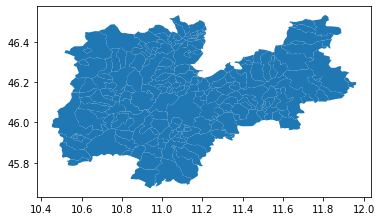

In [76]:
adm_gdf = gpd.GeoDataFrame(adm_json['features'])
adm_gdf.plot()

In [77]:
 trento = adm_gdf.loc[adm_gdf['properties'].apply(lambda row: row['name'] == 'Trento') == True]

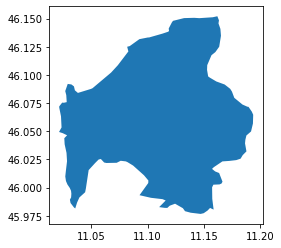

In [78]:
trento['geometry'].plot()

In [79]:
confini_trento = trento['geometry'].loc[142]

In [80]:
celle_giuste = grid.loc[(grid['geometry'].apply(lambda poligono: poligono.within(confini_trento) == True))]

In [81]:
celle_giuste

cellId                                           geometry
1620    4149  POLYGON ((11.13194 45.99318, 11.14484 45.99294...
1706    4264  POLYGON ((11.10647 46.00266, 11.11938 46.00242...
1707    4265  POLYGON ((11.11938 46.00242, 11.13228 46.00218...
1708    4266  POLYGON ((11.13228 46.00218, 11.14519 46.00194...
1789    4375  POLYGON ((11.02936 46.01305, 11.04227 46.01282...
...      ...                                                ...
3102    6020  POLYGON ((11.12455 46.13733, 11.13749 46.13709...
3103    6021  POLYGON ((11.13749 46.13709, 11.15043 46.13685...
3104    6022  POLYGON ((11.15043 46.13685, 11.16336 46.13660...
3207    6137  POLYGON ((11.12490 46.14632, 11.13784 46.14608...
3208    6138  POLYGON ((11.13784 46.14608, 11.15078 46.14584...

[119 rows x 2 columns]

In [82]:
lines

SQUAREID    LINESET  NR_UBICAZIONI
0          155  DG1031221              4
1          272  DG1031221             72
2          273  DG1031221             21
3          276  DG1003117             34
4          277  DG1003117              3
...        ...        ...            ...
2570     10983  DG1013504              5
2571     10984  DG1013504              2
2572     11097  DG1013503              1
2573     11098  DG1013503              6
2574     11099  DG1013503              3

[2575 rows x 3 columns]

In [83]:
cons_nov_mattina.drop('fascia_oraria', axis=1)
cons_nov_sera.drop('fascia_oraria', axis=1)
cons_dec_mattina.drop('fascia_oraria', axis=1)
cons_dec_sera.drop('fascia_oraria', axis=1)

LINESET         TIMESTAMP      POWER
120     DG1000420  2013-12-01 20:00  52.739998
121     DG1000420  2013-12-01 20:10  52.199997
122     DG1000420  2013-12-01 20:20  51.119999
123     DG1000420  2013-12-01 20:30  51.119999
124     DG1000420  2013-12-01 20:40  51.119999
...           ...               ...        ...
821371  DG1056626  2013-12-31 23:10  79.574997
821372  DG1056626  2013-12-31 23:20  78.625000
821373  DG1056626  2013-12-31 23:30  77.025002
821374  DG1056626  2013-12-31 23:40  76.125000
821375  DG1056626  2013-12-31 23:50  75.775002

[136896 rows x 3 columns]

In [84]:
nov_day = cons_nov_mattina.groupby(['LINESET'])['POWER'].sum()
nov_night = cons_nov_sera.groupby(['LINESET'])['POWER'].sum()
dec_day = cons_dec_mattina.groupby(['LINESET'])['POWER'].sum()
dec_night = cons_dec_sera.groupby(['LINESET'])['POWER'].sum()

nov_day.head()

LINESET
DG1000420    138584.693890
DG1000421     45619.618084
DG1000422     57029.277511
DG1000423     42652.258103
DG1000425     67933.736951
Name: POWER, dtype: float64

In [85]:
lines.head()

SQUAREID    LINESET  NR_UBICAZIONI
0       155  DG1031221              4
1       272  DG1031221             72
2       273  DG1031221             21
3       276  DG1003117             34
4       277  DG1003117              3

In [86]:
line_1 = lines.groupby(['LINESET'])['NR_UBICAZIONI'].sum()
line_1.head()

LINESET
DG1000011       6
DG1000023      62
DG1000420    2133
DG1000421    1424
DG1000422    3423
Name: NR_UBICAZIONI, dtype: int64

In [87]:
new_nov_day = pd.merge(lines,cons_nov_mattina,on='LINESET',how='inner',indicator=True)
new_nov_night = pd.merge(lines,cons_nov_sera,on='LINESET',how='inner',indicator=True)
new_dec_day = pd.merge(lines,cons_dec_mattina,on='LINESET',how='inner',indicator=True)
new_dec_night = pd.merge(lines,cons_dec_sera,on='LINESET',how='inner',indicator=True)

new_nov_day

SQUAREID    LINESET  NR_UBICAZIONI         TIMESTAMP       POWER  \
0             155  DG1031221              4  2013-11-02 08:00   36.959999   
1             155  DG1031221              4  2013-11-02 08:10   37.559998   
2             155  DG1031221              4  2013-11-02 08:20   42.480000   
3             155  DG1031221              4  2013-11-02 08:30   44.639999   
4             155  DG1031221              4  2013-11-02 08:40   45.599998   
...           ...        ...            ...               ...         ...   
5279683     10984  DG1013504              2  2013-11-30 19:10  164.625000   
5279684     10984  DG1013504              2  2013-11-30 19:20  164.175003   
5279685     10984  DG1013504              2  2013-11-30 19:30  166.199997   
5279686     10984  DG1013504              2  2013-11-30 19:40  164.274994   
5279687     10984  DG1013504              2  2013-11-30 19:50  165.199997   

         fascia_oraria _merge  
0                    1   both  
1                    1   both  
2                    1   both  
3                    1   both  
4                    1   both  
...                ...    ...  
5279683              1   both  
5279684              1   both  
5279685              1   both  
5279686              1   both  
5279687              1   both  

[5279688 rows x 7 columns]

In [88]:
tot_ubic = lines.groupby(['LINESET'])['NR_UBICAZIONI'].sum()
tot_ubic.head()

LINESET
DG1000011       6
DG1000023      62
DG1000420    2133
DG1000421    1424
DG1000422    3423
Name: NR_UBICAZIONI, dtype: int64

In [89]:
celle_giuste

cellId                                           geometry
1620    4149  POLYGON ((11.13194 45.99318, 11.14484 45.99294...
1706    4264  POLYGON ((11.10647 46.00266, 11.11938 46.00242...
1707    4265  POLYGON ((11.11938 46.00242, 11.13228 46.00218...
1708    4266  POLYGON ((11.13228 46.00218, 11.14519 46.00194...
1789    4375  POLYGON ((11.02936 46.01305, 11.04227 46.01282...
...      ...                                                ...
3102    6020  POLYGON ((11.12455 46.13733, 11.13749 46.13709...
3103    6021  POLYGON ((11.13749 46.13709, 11.15043 46.13685...
3104    6022  POLYGON ((11.15043 46.13685, 11.16336 46.13660...
3207    6137  POLYGON ((11.12490 46.14632, 11.13784 46.14608...
3208    6138  POLYGON ((11.13784 46.14608, 11.15078 46.14584...

[119 rows x 2 columns]

In [90]:
nov_day_2 = pd.merge(new_nov_day, tot_ubic, on='LINESET',how='inner')
nov_night_2 = pd.merge(new_nov_night, tot_ubic, on='LINESET',how='inner')
dec_day_2 = pd.merge(new_dec_day, tot_ubic, on='LINESET',how='inner')
dec_night_2 = pd.merge(new_dec_night, tot_ubic, on='LINESET',how='inner')

nov_day_2

SQUAREID    LINESET  NR_UBICAZIONI_x         TIMESTAMP       POWER  \
0             155  DG1031221                4  2013-11-02 08:00   36.959999   
1             155  DG1031221                4  2013-11-02 08:10   37.559998   
2             155  DG1031221                4  2013-11-02 08:20   42.480000   
3             155  DG1031221                4  2013-11-02 08:30   44.639999   
4             155  DG1031221                4  2013-11-02 08:40   45.599998   
...           ...        ...              ...               ...         ...   
5279683     10984  DG1013504                2  2013-11-30 19:10  164.625000   
5279684     10984  DG1013504                2  2013-11-30 19:20  164.175003   
5279685     10984  DG1013504                2  2013-11-30 19:30  166.199997   
5279686     10984  DG1013504                2  2013-11-30 19:40  164.274994   
5279687     10984  DG1013504                2  2013-11-30 19:50  165.199997   

         fascia_oraria _merge  NR_UBICAZIONI_y  
0                    1   both             1380  
1                    1   both             1380  
2                    1   both             1380  
3                    1   both             1380  
4                    1   both             1380  
...                ...    ...              ...  
5279683              1   both               74  
5279684              1   both               74  
5279685              1   both               74  
5279686              1   both               74  
5279687              1   both               74  

[5279688 rows x 8 columns]

In [91]:
nov_day_2['POWER_CELLID'] = nov_day_2['POWER']* nov_day_2['NR_UBICAZIONI_x'] / nov_day_2['NR_UBICAZIONI_y']
nov_night_2['POWER_CELLID'] = nov_night_2['POWER']* nov_night_2['NR_UBICAZIONI_x'] / nov_night_2['NR_UBICAZIONI_y']
dec_day_2['POWER_CELLID'] = dec_day_2['POWER']* dec_day_2['NR_UBICAZIONI_x'] / dec_day_2['NR_UBICAZIONI_y']
dec_night_2['POWER_CELLID'] = dec_night_2['POWER']* dec_night_2['NR_UBICAZIONI_x'] / dec_night_2['NR_UBICAZIONI_y']

nov_day_2

SQUAREID    LINESET  NR_UBICAZIONI_x         TIMESTAMP       POWER  \
0             155  DG1031221                4  2013-11-02 08:00   36.959999   
1             155  DG1031221                4  2013-11-02 08:10   37.559998   
2             155  DG1031221                4  2013-11-02 08:20   42.480000   
3             155  DG1031221                4  2013-11-02 08:30   44.639999   
4             155  DG1031221                4  2013-11-02 08:40   45.599998   
...           ...        ...              ...               ...         ...   
5279683     10984  DG1013504                2  2013-11-30 19:10  164.625000   
5279684     10984  DG1013504                2  2013-11-30 19:20  164.175003   
5279685     10984  DG1013504                2  2013-11-30 19:30  166.199997   
5279686     10984  DG1013504                2  2013-11-30 19:40  164.274994   
5279687     10984  DG1013504                2  2013-11-30 19:50  165.199997   

         fascia_oraria _merge  NR_UBICAZIONI_y  POWER_CELLID  
0                    1   both             1380      0.107130  
1                    1   both             1380      0.108870  
2                    1   both             1380      0.123130  
3                    1   both             1380      0.129391  
4                    1   both             1380      0.132174  
...                ...    ...              ...           ...  
5279683              1   both               74      4.449324  
5279684              1   both               74      4.437162  
5279685              1   both               74      4.491892  
5279686              1   both               74      4.439865  
5279687              1   both               74      4.464865  

[5279688 rows x 9 columns]

In [92]:
nov_day_3 = nov_day_2.groupby(['SQUAREID'])['POWER_CELLID'].sum()
nov_night_3 = nov_night_2.groupby(['SQUAREID'])['POWER_CELLID'].sum()
dec_day_3 = dec_day_2.groupby(['SQUAREID'])['POWER_CELLID'].sum()
dec_night_3 = dec_night_2.groupby(['SQUAREID'])['POWER_CELLID'].sum()

nov_day_3

SQUAREID
155       300.750138
272      5413.502488
273      1578.938226
276      3069.060663
277       270.799470
            ...     
10983    7226.455519
10984    2890.582208
11097     102.554326
11098     615.325959
11099     307.662979
Name: POWER_CELLID, Length: 1984, dtype: float64

In [93]:
nov_giorno = pd.DataFrame(nov_day_3)
nov_notte = pd.DataFrame(nov_night_3)
dec_giorno = pd.DataFrame(dec_day_3)
dec_notte = pd.DataFrame(dec_night_3)

In [95]:
tsh = [['treshold novembre giorno', np.percentile(nov_giorno['POWER_CELLID'], 67)], ['treshold novembre notte', np.percentile(nov_notte['POWER_CELLID'], 67)], ['treshold dicembre giorno', np.percentile(dec_giorno['POWER_CELLID'], 67)], ['treshold dicembre notte', np.percentile(dec_notte['POWER_CELLID'], 67)]]
treshold = pd.DataFrame(tsh, columns=['Name', 'Values'])

treshold

Name       Values
0  treshold novembre giorno  2771.501219
1   treshold novembre notte   880.941907
2  treshold dicembre giorno  3355.309485
3   treshold dicembre notte  1090.440913

In [38]:
celle_giuste.head(120)

cellId                                           geometry
1620    4149  POLYGON ((11.13194 45.99318, 11.14484 45.99294...
1706    4264  POLYGON ((11.10647 46.00266, 11.11938 46.00242...
1707    4265  POLYGON ((11.11938 46.00242, 11.13228 46.00218...
1708    4266  POLYGON ((11.13228 46.00218, 11.14519 46.00194...
1789    4375  POLYGON ((11.02936 46.01305, 11.04227 46.01282...
...      ...                                                ...
3102    6020  POLYGON ((11.12455 46.13733, 11.13749 46.13709...
3103    6021  POLYGON ((11.13749 46.13709, 11.15043 46.13685...
3104    6022  POLYGON ((11.15043 46.13685, 11.16336 46.13660...
3207    6137  POLYGON ((11.12490 46.14632, 11.13784 46.14608...
3208    6138  POLYGON ((11.13784 46.14608, 11.15078 46.14584...

[119 rows x 2 columns]

In [55]:
nov_day_ready = pd.merge(left = nov_day_3, right = celle_giuste, how="right", left_index= True, right_on = 'cellId')
nov_night_ready = pd.merge(left = nov_night_3, right = celle_giuste, how="outer", left_index= True, right_on = 'cellId')
dec_day_ready = pd.merge(left = dec_day_3, right = celle_giuste, how="outer", left_index= True, right_on = 'cellId')
dec_night_ready = pd.merge(left = dec_night_3, right = celle_giuste, how="outer", left_index= True, right_on = 'cellId')

In [59]:
nov_day_ready['POWER_CELLID'] = nov_day_ready['POWER_CELLID'].fillna(0)
nov_night_ready['POWER_CELLID'] = nov_night_ready['POWER_CELLID'].fillna(0)
dec_day_ready['POWER_CELLID'] = dec_day_ready['POWER_CELLID'].fillna(0)
dec_night_ready['POWER_CELLID'] = dec_night_ready['POWER_CELLID'].fillna(0)

In [67]:
map_nov_day = gpd.GeoDataFrame(nov_day_ready)
map_nov_night = gpd.GeoDataFrame(nov_night_ready)
map_dec_day = gpd.GeoDataFrame(dec_day_ready)
map_dec_night = gpd.GeoDataFrame(dec_night_ready)

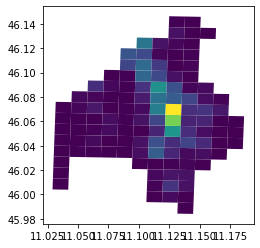

In [68]:
map_nov_day.plot('POWER_CELLID')